<a href="https://colab.research.google.com/github/gautamankitkumar/ankitgau-ms-report-data/blob/main/notebooks/generate-DFT-configs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This notebook generates the dataset consisting of configurations of various sizes and compositions. These atomic slabs are required to train our Behler-Parinello Neural Network.

# Methods
We generated atomic slabs of various sizes and compositions totalling to 4000 in number. 5 sizes (number of atoms) of slabs were chosen to build the dataset. Compositions were chosen using `np.random.dirichlet` as found [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.dirichlet.html) to have slabs with distinct composition which cover the ternary space of compositions.

To capture various local environment as experienced by atoms, slabs of 5 lattice constants were created at varying lattice constants from lowest (Copper, 3.63 $\overset{\lower.5em\circ}{\mathrm{A}}$ ) to highest (Gold, 4.17 $\overset{\lower.5em\circ}{\mathrm{A}}$).

Slabs were created for unequal number for each size, with increased number of bigger slabs. For each lattice constant, the slabs are as follows:

- 100 of 1 $\times$ 1 $\times$ 7
- 100 of 2 $\times$ 1 $\times$ 7
- 200 of $\sqrt{3} \times \sqrt{3} \times 7$
- 200 of $\sqrt{7} \times \sqrt{7} \times 5$
- 100 of 3 $\times$ 3 $\times$ 5

`itertools.product` was used to loop over varying size of the slabs and number of configurations for each lattice constant.

`EMT()` calculator as provided by [ase](https://wiki.fysik.dtu.dk/ase/ase/calculators/emt.html) was used as a filter to only include energy unique configurations.

Note: Databases in ase start from index 1.

In [ ]:
! pip install ase python-ternary

In [1]:
from ase.build import fcc111,fcc111_root
from ase.calculators.emt import EMT
import numpy as np
import matplotlib.pyplot as plt
from ase.db import connect
import ternary
import os
%matplotlib inline

from itertools import product
from ase.build import fcc111_root

In [5]:
# Define bulk lattice constant as found in earlier calculations

Cu_lc = 3.6388 # in Angstroms
Ag_lc = 4.1628
Au_lc = 4.1735

elements = ['Cu', 'Ag', 'Au']  # [1, 2, 3 in the param_set]

In [15]:
def gen_dir_comp(alpha, n_atoms, size):
    """
    Function to generate compositions according to Dirichlet distribution
    alpha: float: Dirichlet distribution parameter
    n_atoms: int: len(atoms)
    size: int: number of compositions to be return
    """
    all_comps = np.random.dirichlet((alpha, alpha, alpha), size=size) * n_atoms
    all_comps = np.rint(all_comps)  # rounding to close integer
    all_comps[:, 2] = n_atoms - np.sum(all_comps[:, :2], axis=1)  # constrain the sum equal to n_atoms
    all_comps = all_comps.astype(int)
    return all_comps

def plot_ternary(comps, scale, elements):
    """
    Function to plot compositions in ternary diagram
    elements: list of string: should be in the same order in comps
    comps: array: composition
    scale: int: scale of composition

    """
    # Rest of the code is to plot the obtained combinations on ternary diagram
    fig = plt.figure(figsize=(12, 8))
    fontsize=20
    ax = fig.add_subplot(111)
    ax.axis('off')
    figure, tax = ternary.figure(scale=scale, ax=ax)
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="blue", multiple=5)

    # Set Axis labels and Title
    tax.right_corner_label(elements[0], fontsize=fontsize)
    tax.top_corner_label(elements[1], fontsize=fontsize)
    tax.left_corner_label(elements[2], fontsize=fontsize)
    
    tax.scatter(comps)

    tax.ticks(axis='lbr', multiple=5, linewidth=2, fontsize=fontsize, offset=0.02)
    tax.clear_matplotlib_ticks()
    tax.show()

In [16]:


if os.path.isfile('temp.db'):
    os.remove('temp.db')

# Connet to a Temp database
db = connect('temp.db')


# Define the size and its number for each lattice constant
size_and_number = [((1,1,7),100),     #1 by 1 by 7 
                   ((2,1,7),100),     #2 by 1 by 7
                   ((3,3,7),200),     #r3 by r3 by 7
                   ((7,7,5),200),     #r7 by r7 by 5
                   ((3,3,5),200)]     #3 by 3 by 5

# Create a linear spacing of lattice constants
all_LC = [Cu_lc,Ag_lc,Au_lc]
LC = np.linspace(min(all_LC),max(all_LC),5)

nrg_list = []    # Initialize list to contain energy of configurations sampled till now
images = []      # Initialize empty list to contain the atoms object of each config
comps = []       # To hold compositions for configs


total_count = 0   # This can be used to track all the Vasp calculators with a id.


# This single code to loop over all the sizes and lattice constants
for ((cell_size,number),lc) in product(size_and_number,LC): 
    
    """
    Cell_size: will be tuple of the cell size dimension
    number: denotes how many sample per each LC
    lc: contains the lattice constant in Angstrom
    """
    
    # Reset count to Zero
    count = 0
    
    # number of configs for current size
    N_per_lc = number
    
    while count < N_per_lc:
        
        # Different initialization for the root and conventional unit cell
        if cell_size in [(1,1,7),(2,1,7),(3,3,5)]:
            atoms = fcc111('Au', size=cell_size, a=lc, vacuum=10)
        else:
            atoms = fcc111_root('Au',size=(1,1,cell_size[2]),root=cell_size[0], a=lc, vacuum=10)
            
        # Using alpha same for all the configurations
        n_0, n_1, n_2 = gen_dir_comp(alpha=1.3, n_atoms=len(atoms), size=1)[0]
        symbols = [elements[0]] * n_0 + [elements[1]] * n_1 + [elements[2]] * n_2
        np.random.shuffle(symbols)

        atoms.set_chemical_symbols(symbols)
        atoms.set_calculator(EMT())
        nrg = atoms.get_potential_energy()
        
        if nrg not in nrg_list:
            nrg_list.append(nrg)
            images.append(atoms)
            comps.append(np.array([n_0, n_1, n_2])*100/len(atoms))
            count = count + 1
            
            calc_id = db.write(atoms)
        else:
            N_per_lc+=1

After running the above code cell, a file `temp.db` should have been generated containing 4000 configurations. We can visualize the created slabs with the help of helper functions defined earlier.

## Plot compositions on a ternary diagram

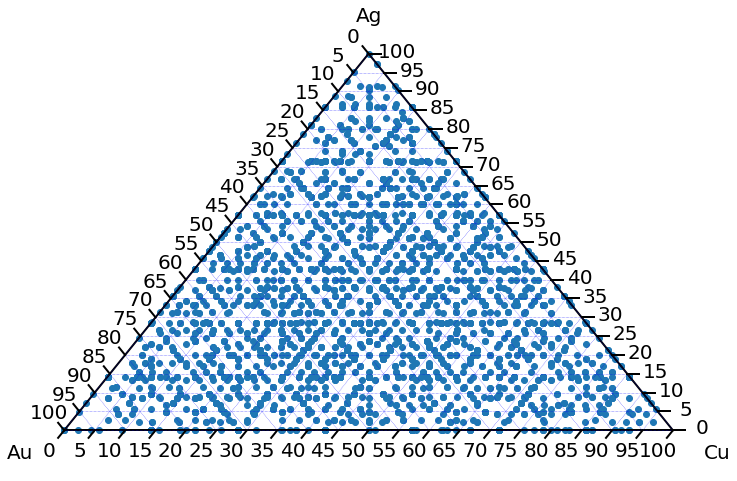

In [17]:
plot_ternary(comps,100,elements)

With the `temp.db` file available to us, `atoms` objects out of these files are easily obtained for future purposes. The sampling of configurations was done on a local PC and then moved to cluster to be used in Vasp calculations. Similar graph for the datapoints used for the project is generated at the bottom of this notebook for comparison.

# Using datapoints in Vasp

Using the previously generated datapoints, Vasp calculations are queued on the cluster. Calculators are named on their calculation ID i.e. names as `CuAgAu_0`, `CuAgAu_1` and so on till `CuAgAu_3999`.

The following code cell is not intended to be executed on Google colab but is included for reference.

In [2]:
from vasp import Vasp
from ase.db import connect

# Contains all the configurations generated above
old_db = connect('temp.db')

images = list(old_db.select())

# Choose the IDs to start calculations
queue_range = np.arange(0,200)


for ind in queue_range:
    atoms = old_db.get_atoms(select = ind+1)
    number_of_atoms = len(atoms)
    
    if number_of_atoms == 7:  # 1 1 7
        kpts = [10, 10, 1]
    elif number_of_atoms == 14:  # 2 1 7
        kpts = [5, 10, 1]
    elif number_of_atoms == 21:  # r3r37
        kpts = [6, 6, 1]
    elif number_of_atoms == 35:  # r7r75
        kpts = [4, 4, 1]
    elif number_of_atoms == 45:  # 3 3 5
        kpts = [3, 3, 1]
        
    # Create new directory for each new calculation
    filename = 'sampling/CuAgAutest' + imagename
    new_atoms = db.get_atoms(selection=count+1)
    calc = Vasp(filename, xc='PBE', encut=400, kpts=kpts, atoms=new_atoms)
    print(calc.potential_energy)

# Ternary plot for sampled data used in this project

First, copy the dataset from github repo.

In [ ]:
! git clone https://github.com/gautamankitkumar/ankitgau-ms-report-data.git

After the following commands, we should have a named `CuAgAu-sampling-datapoints.db` in our path

In [ ]:
ref_comps = []
ref_db = connect('ankitgau-ms-report-data/data/CuAgAu-sampling-datapoints.db')
for i in range(4000):
    atoms = ref_db.get_atoms(selection=i+1)
    syms = atoms.get_chemical_symbols()
    n_cu,n_ag,n_au = np.array([syms.count('Cu'),syms.count('Ag'),syms.count('Au')])*100/len(atoms)
    ref_comps.append([n_cu,n_ag,n_au])

plot_ternary(ref_comps,100,elements)